In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from joblib import Parallel, delayed
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [4]:
df = pd.read_csv("estadisticas_partidos.csv")
df =  df.sort_index(axis=0, ascending=False, ignore_index=True)

In [5]:
home_win = 0
away_win = 0
draw = 0
for i in range(len(df)):
    if df.iloc[i]["score_home"] > df.iloc[i]["score_away"]:
        home_win +=1
    elif df.iloc[i]["score_away"] > df.iloc[i]["score_home"]:
        away_win +=1
    elif df.iloc[i]["score_away"] == df.iloc[i]["score_home"]:
        draw +=1
    df.iloc[i]['duels_won_home'] > df.iloc[i]['duels_won_away']

total = len(df)
home_win_percentage = home_win/total
away_win_percentage = away_win/total
draw_perentage = draw/total

In [6]:
print(home_win_percentage)
print(away_win_percentage)
print(draw_perentage)

0.4041666666666667
0.35
0.24583333333333332


In [7]:
def get_features(data, side):
    if side == "home":
        return data[2:].values
    elif side == "away": 
        original_lista = data.keys()[2:]
        nueva_lista = [item.replace('home', 'temp').replace('away', 'home').replace('temp', 'away') for item in original_lista]
        return data.get(nueva_lista).values



In [8]:
len(df.columns)

60

In [9]:
def search_features(i, df, last_games):
    # W = home_win, D = draw, L = home_lose
    team_home = df.iloc[i]["team_home"]
    team_away = df.iloc[i]["team_away"]
    home_search = last_games
    away_search = last_games
    # W = win, D = draw, L = lose
    info_home = []
    info_away = []
    info_features_home = []
    info_features_away = []
    df_match1 = df[df["team_home"] == team_home]
    df_match2 = df[df["team_away"] == team_home]
    df_match3 = df[df["team_home"] == team_away]
    df_match4 = df[df["team_away"] == team_away]
    df_match_index = sorted(list(set(df_match1.index) | set(df_match2.index) | set(
        df_match3.index) | set(df_match4.index)), reverse=True)
    for j in df_match_index:

        if away_search == 0 and home_search == 0:
            features_home_games = np.sum(info_features_home, axis=0)/last_games
            features_away_games = np.sum(info_features_away, axis=0)/last_games
            if df.iloc[i]["score_home"] > df.iloc[i]["score_away"]:
                result = "W"
            elif df.iloc[i]["score_home"] == df.iloc[i]["score_away"]:
                result = "D"
            elif df.iloc[i]["score_home"] < df.iloc[i]["score_away"]:
                result = "L"
            return info_home, info_away, result, features_home_games, features_away_games
        # Buscamos los partidos anteriores del equipo de CASA

        if home_search > 0 and i-j > 0:
            if team_home == df.iloc[j]["team_home"]:
                info_features_home.append(
                    get_features(df.iloc[j], side="home"))
                # Casa gana
                if df.iloc[j]["score_home"] > df.iloc[j]["score_away"]:
                    home_search -= 1
                    info_home.append("W")
                # Casa pierde
                elif df.iloc[j]["score_home"] < df.iloc[j]["score_away"]:
                    home_search -= 1
                    info_home.append("L")
                # Casa empata
                elif df.iloc[j]["score_home"] == df.iloc[j]["score_away"]:
                    home_search -= 1
                    info_home.append("D")
            elif team_home == df.iloc[j]["team_away"]:
                info_features_home.append(
                    get_features(df.iloc[j], side="away"))
                # Visita gana
                if df.iloc[j]["score_away"] > df.iloc[j]["score_home"]:
                    home_search -= 1
                    info_home.append("W")
                # Visita pierde
                elif df.iloc[j]["score_away"] < df.iloc[j]["score_home"]:
                    home_search -= 1
                    info_home.append("L")
                # Visita empata
                elif df.iloc[j]["score_away"] == df.iloc[j]["score_home"]:
                    home_search -= 1
                    info_home.append("D")

        # Buscamos los partidos anteriores del equipo de VISITA
        if away_search > 0 and i-j > 0:
            if team_away == df.iloc[j]["team_home"]:
                info_features_away.append(
                    get_features(df.iloc[j], side="home"))
                # Casa gana
                if df.iloc[j]["score_home"] > df.iloc[j]["score_away"]:
                    away_search -= 1
                    info_away.append("W")
                # Casa pierde
                elif df.iloc[j]["score_home"] < df.iloc[j]["score_away"]:
                    away_search -= 1
                    info_away.append("L")
                # Casa empata
                elif df.iloc[j]["score_home"] == df.iloc[j]["score_away"]:
                    away_search -= 1
                    info_away.append("D")
            elif team_away == df.iloc[j]["team_away"]:
                info_features_away.append(
                    get_features(df.iloc[j], side="away"))
                # Visita gana
                if df.iloc[j]["score_away"] > df.iloc[j]["score_home"]:
                    away_search -= 1
                    info_away.append("W")
                # Visita pierde
                elif df.iloc[j]["score_away"] < df.iloc[j]["score_home"]:
                    away_search -= 1
                    info_away.append("L")
                # Visita empata
                elif df.iloc[j]["score_away"] == df.iloc[j]["score_home"]:
                    away_search -= 1
                    info_away.append("D")

In [10]:
last_games = 3
num_trabajadores = -1
resultados = Parallel(n_jobs=num_trabajadores,verbose=10)(
    delayed(search_features)(i, df, last_games) for i in range(len(df)))
resultados_limpios = []
for i in range(len(resultados)):
    if resultados[i] != None:
        resultados_limpios.append(resultados[i])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.17714226776297382s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.06019401550292969s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.06828689575195312s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done 131 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 185 tasks      | elapsed:    1.4s
[Parallel(n_job

In [11]:
len(resultados_limpios)

208

In [12]:
X = []
Y = []

for i in range(len(resultados_limpios)):
    streak_home = resultados_limpios[i][0]
    streak_away = resultados_limpios[i][1]
    result = resultados_limpios[i][2]

    features_home_games = resultados_limpios[i][3]
    features_away_games = resultados_limpios[i][4]

    home_wins = streak_home.count("W")
    home_draws = streak_home.count("D")
    home_lose = streak_home.count("L")

    away_wins = streak_away.count("W")
    away_draws = streak_away.count("D")
    away_lose = streak_away.count("L")

    features = [home_wins, home_draws, home_lose,
                away_wins, away_draws, away_lose,
                *features_home_games, *features_away_games]
    # Con factor temporal
    for match in streak_home:
        if match == "W":
            features.extend([1, 0, 0])
        elif match == "D":
            features.extend([0, 1, 0])
        elif match == "L":
            features.extend([0, 0, 1])

    for match in streak_away:
        if match == "W":
            features.extend([1, 0, 0])
        elif match == "D":
            features.extend([0, 1, 0])
        elif match == "L":
            features.extend([0, 0, 1])
    X.append(features)
    if result == "W":
        Y.append([1, 0, 0])
    elif result == "D":
        Y.append([0, 1, 0])
    elif result == "L":
        Y.append([0, 0, 1])

In [13]:
from sklearn import preprocessing
X_array = np.array(X)
scaler = preprocessing.StandardScaler()
X_array_escalado = scaler.fit_transform(X_array)
Y_array = np.array(Y)

In [14]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_array_escalado, Y_array, test_size=0.2)

model = model = models.Sequential()
model.add(layers.InputLayer(input_shape=(len(X[0]),)))
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(2048, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(2048, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(2048, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(3, activation='softmax'))
# # Compilamos el modelo
model.compile(loss='categorical_crossentropy',
              optimizer="adam", metrics=['accuracy',])

# # Entrenamos el modelo
history = model.fit(X_train, y_train, verbose=1, epochs=1000, validation_data=(X_test,y_test))

Epoch 1/1000
6/6 [==============================] - 1s 113ms/step - loss: 1.5333 - accuracy: 0.3916 - val_loss: 1.1272 - val_accuracy: 0.3333
Epoch 2/1000
6/6 [==============================] - 1s 89ms/step - loss: 1.0541 - accuracy: 0.4036 - val_loss: 1.2225 - val_accuracy: 0.2381
Epoch 3/1000
6/6 [==============================] - 1s 89ms/step - loss: 0.9051 - accuracy: 0.5422 - val_loss: 1.5633 - val_accuracy: 0.3810
Epoch 4/1000
6/6 [==============================] - 1s 89ms/step - loss: 0.6415 - accuracy: 0.6747 - val_loss: 1.5491 - val_accuracy: 0.3571
Epoch 5/1000
6/6 [==============================] - 1s 93ms/step - loss: 0.4494 - accuracy: 0.8494 - val_loss: 2.5107 - val_accuracy: 0.3333
Epoch 6/1000
6/6 [==============================] - 1s 89ms/step - loss: 0.2502 - accuracy: 0.9096 - val_loss: 3.5527 - val_accuracy: 0.3571
Epoch 7/1000
6/6 [==============================] - 1s 88ms/step - loss: 0.0732 - accuracy: 0.9759 - val_loss: 4.5070 - val_accuracy: 0.3095
Epoch 8/1000

KeyboardInterrupt: 

2/2 [==============================] - 0s 2ms/step
Matriz de Confusión:


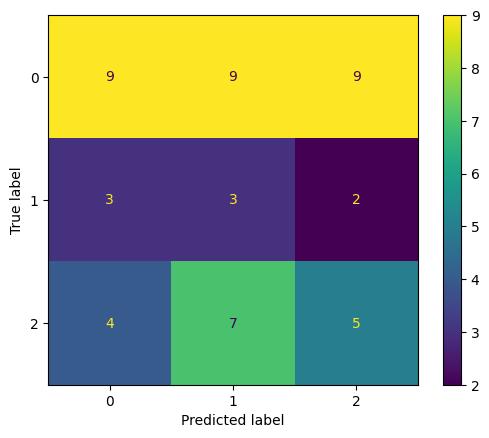

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


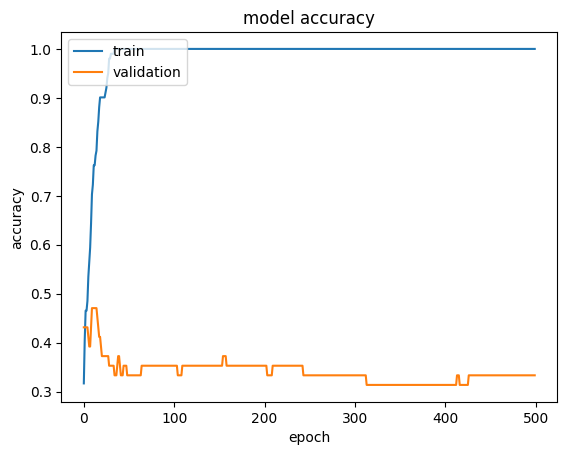

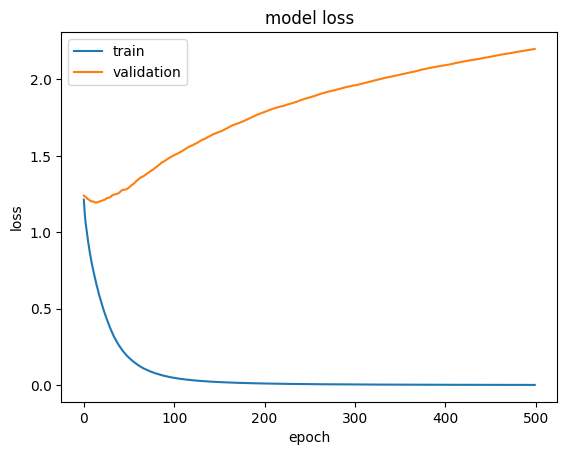

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay
y_prob = model.predict(X_test)
y_test_metrics = np.argmax(y_test, axis=1)
y_pred = np.argmax(y_prob, axis=1)


# Matriz de confusión
conf_matrix = confusion_matrix(y_test_metrics, y_pred)
print('Matriz de Confusión:')
ConfusionMatrixDisplay(conf_matrix).plot()
plt.show()
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [202]:
print(classification_report(y_test_metrics, y_pred))


              precision    recall  f1-score   support

           0       0.56      0.38      0.45        24
           1       0.20      0.30      0.24        10
           2       0.40      0.47      0.43        17

    accuracy                           0.39        51
   macro avg       0.39      0.38      0.37        51
weighted avg       0.44      0.39      0.40        51

